# **Step1_AI면접관 Agent v1.0**

## 🧐 **수정 내용**
1. 피드백 고도화 부분 콘솔에 print 되고 gradio 에는 다른 피드백이 표시되는 상황

  *   summarize_interview 에서 생성된 내용을 state에 저장하여 보여주는 방법으로 수정 시도

2. 답변 평가 시 무한루프에 빠질 수 있음

  * State에 re_evaluate_count 항목 추가
  * update_evalute_state, decide_evalute_again_edge를 통해 SRP를 유지하며 state update과 분기 설정

3. 기존 코드에서 docx 실행불가

  * import 문제 수정






## 🚀 **고도화 현황**

* 인터뷰 진행 고도화 ✅
* 피드백 보고서 고도화 ✅
* 답변 평가 고도화 ✅
* 질문 생성 고도화 ✅

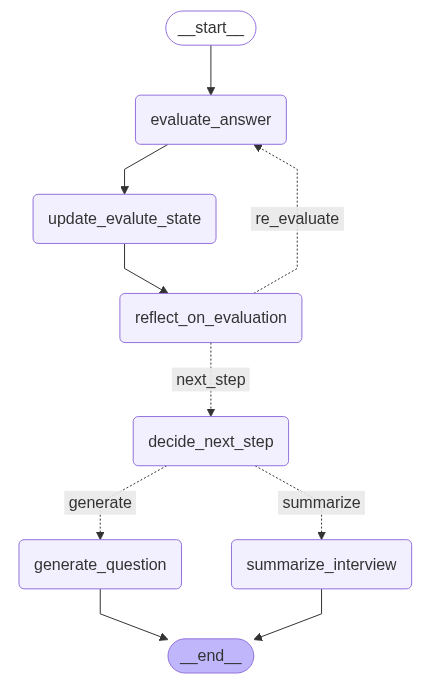
---

## **1. 환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project_genai)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 라이브러리

In [16]:
!pip install -r /content/drive/MyDrive/project_genai/requirements.txt -q

### (3) OpenAI API Key 확인
* api_key.txt 파일에 다음의 키를 등록하세요.
    * OPENAI_API_KEY
    * NGROK_AUTHTOKEN

In [17]:
import os

def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [18]:
print(os.environ['OPENAI_API_KEY'][:30])

sk-proj-dzp-JIMqWPxLr3pZKZ1QBq


## **2. App.py**

* 아래 코드에, Step1 혹은 고도화 된 Step2 파일 코드를 붙인다.
    * 라이브러리
    * 함수들과 그래프
* Gradio 코드는 그대로 사용하거나 일부 수정 가능

In [21]:
%%writefile app.py

####### 여러분의 함수와 클래스를 모드 여기에 붙여 넣읍시다. #######
## 1. 라이브러리 로딩 ---------------------------------------------
import pandas as pd
import numpy as np
import os
import openai
import random
import ast
import fitz

from docx import Document as DocxDocument

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict, List, Dict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.output_parsers import CommaSeparatedListOutputParser, PydanticOutputParser
from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel

## ---------------- 1단계 : 사전준비 ----------------------

# 1) 파일 입력 --------------------
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text
    elif ext == ".docx":
        doc = DocxDocument(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())
    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")

# 2) State 선언 --------------------
class StrategySection(BaseModel):
    질문방향: str
    예시질문: list[str]

class InterviewStrategy(BaseModel):
    경력_및_경험: StrategySection
    동기_및_커뮤니케이션: StrategySection
    논리적_사고: StrategySection

class Evaluation(BaseModel):
    질문과의_관련성: str
    답변의_구체성: str

class InterviewState(TypedDict):
    # 고정 정보
    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: InterviewStrategy

    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    conversation: List[Dict[str, str]]
    evaluation : List[Evaluation]
    strategies: List[str]
    next_step : str
    reflection_status: str

    ## 1. 수정 부분
    feedback_report: str

    ## 2. 수정 부분
    re_evaluate_count: int


# 3) resume 분석 --------------------
def analyze_resume(state: InterviewState) -> InterviewState:
    resume_text = state.get("resume_text", "")
    if not resume_text:
        raise ValueError("resume_text가 비어 있습니다. 먼저 텍스트를 추출해야 합니다.")

    llm = ChatOpenAI(model="gpt-4o-mini")

    # 요약 프롬프트 구성
    summary_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서 내용에서 질문을 뽑기 위한 중요한 내용을 10문장 정도로 요약을 해줘(요약시 ** 기호는 사용하지 말것):\n\n{resume_text}'''
    )
    formatted_summary_prompt = summary_prompt.format(resume_text=resume_text)
    summary_response = llm.invoke(formatted_summary_prompt)
    resume_summary = summary_response.content.strip()

    # 키워드 추출 프롬프트 구성
    keyword_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서내용에서 질문을 뽑기 위한 중요한 핵심 키워드를 5~10개 추출해줘. 도출한 핵심 키워드만 쉼표로 구분해줘:\n\n{resume_text}'''
    )
    formatted_keyword_prompt = keyword_prompt.format(resume_text=resume_text)
    keyword_response = llm.invoke(formatted_keyword_prompt)

    parser = CommaSeparatedListOutputParser()
    resume_keywords = parser.parse(keyword_response.content)

    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
    }

# 4) 질문 전략 수립 --------------------

def generate_question_strategy(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

    prompt = PromptTemplate(
            input_variables=["resume_summary", "resume_keywords"],
            template="""
            [이력서 요약]
            {resume_summary}

            [주요 키워드]
            {resume_keywords}

            -- 면접 전략 생성
            - 다음 3개 영역별로 JSON 형식 생성:
            1. 경력 및 경험: 역할/성과 중심 질문
            2. 동기 및 커뮤니케이션: 가치관/소통능력 평가
            3. 논리적 사고: 문제해결 과정 평가

            -- 출력 형식
            {{
              "경력_및_경험": {{
                "질문방향": "...",
                "예시질문": ["...", "..."]
              }},
              "동기_및_커뮤니케이션": {{
                "질문방향": "...",
                "예시질문": ["...", "..."]
              }},
              "논리적_사고": {{
                "질문방향": "...",
                "예시질문": ["...", "..."]
              }}
            }}
            """
        )

    # 체인 구성
    parser = PydanticOutputParser(pydantic_object=InterviewStrategy)
    chain = prompt | llm | parser

    strategy = chain.invoke({
        "resume_summary": state['resume_summary'],
        "resume_keywords": state['resume_keywords']
    })


    # return 코드는 제공합니다.
    return {
        **state,
        "question_strategy": strategy
    }

# 5) 1단계 하나로 묶기 --------------------

def makeState(resume_text: str) -> InterviewState:
  return {
      "resume_text": resume_text,
      "resume_summary": '',
      "resume_keywords": [],
      "question_strategy": {},

      "current_question": '',
      "current_answer": '',
      "current_strategy": '',
      "conversation": [],
      "evaluation": [],
      "strategies": [],
      "next_step" : '',
      "reflection_status": '',

      # 1. 수정 부분
      "feedback_report": '',

      # 2. 수정 부분
      "re_evaluate_count": 0
  }

def preProcessing_Interview(file_path: str) -> InterviewState:
    # 여기에 코드를 완성합니다.
    resume_text = extract_text_from_file(file_path)
    initial_state = makeState(resume_text)

    analyzed_state = analyze_resume(initial_state)
    state = generate_question_strategy(analyzed_state)

    strategy = state['question_strategy']

    selected_question = strategy.경력_및_경험.예시질문[0]


    # return 코드는 제공합니다.
    return {
            **state,
            "current_question": selected_question,
            "current_strategy": "경력 및 경험"
            }


## ---------------- 2단계 : 면접 Agent ----------------------

# 1) 답변 입력 --------------------
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:
    return {
        **state,
        "current_answer": user_answer.strip()
    }

# 2) 답변 평가 --------------------
def evaluate_answer(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

    prompt = PromptTemplate(
            input_variables=["current_question", "current_answer"],
            template="""
            [질문]
            {current_question}

            [답변]
            {current_answer}

            -- 다음 항목에 대한 답변 평가
            - '상', '중', '하' 로 평가
            - 1. 질문과의 관련성
              - '상': 질문의 핵심 의도 정확히 부함하며, 전반적인 내용을 명확히 다룸
              - '중': 질문과 관련은 있지만 핵심 포인트가 부분적으로 누락됨
              - '하': 질문과 관련이 약하거나 엉뚱한 내용 중심
            - 2. 답변의 구체성
              - '상': 구체적인 사례, 데이터, 단계별 설명 등이 포함되어 명확히 근거를 제시함
              - '중': 일부 구체적 내용이 있으나 추가 설명이나 예시가 부족함
              - '하': 추상적이거나 모호한 표현만 사용되어 핵심 내용이 불분명함

            -- 출력 형식
            {{
              "질문과의_관련성": "...",
              "답변의_구체성": "..."
            }}
            """
        )

    # 체인 구성
    parser = PydanticOutputParser(pydantic_object=Evaluation)
    chain = prompt | llm | parser

    assessment = chain.invoke({
        "current_question": state['current_question'],
        "current_answer": state['current_answer']
    })

    if state['conversation'] and state['conversation'][-1]['question'] == state['current_question']:
        state['conversation'][-1]['answer'] = state['current_answer']
        state['evaluation'][-1] = assessment
    else:
        state['conversation'].append({
            "question": state['current_question'],
            "answer": state['current_answer']
        })
        state['evaluation'].append(assessment)

    state['strategies'].append(state['current_strategy'])

    # return 코드는 제공합니다.

    return {
        **state
    }

def reflect_on_evaluation(state: InterviewState) -> InterviewState:

    llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

    prompt = PromptTemplate(
        input_variables=["current_question",
                         "current_answer",
                         "latest_eval"],
        template="""
        질문과 답변, 그리고 이에 대한 평가 결과를 검토하고, 평가가 답변 내용에 적절하게 이루어졌는지를 판단해주세요.

        [질문]
        {current_question}

        [답변]
        {current_answer}

        [평가]
        {latest_eval}

        - 답변의 내용이 실제로 부실하거나 질문과 맞지 않다면, 평가가 '하'인 것은 타당합니다.
        - 하지만 내용이 구체적이고 적절한데도 평가가 '하'라면, 평가가 부적절할 수 있습니다.
        - 이처럼 평가가 답변에 적절하게 이루어졌다면 1, 부적절하다면 0 라고만 응답해 주세요.

        반환값은 꼭!!!!! 1 또는 0
        """
    )
    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({
        "current_question": state["current_question"],
        "current_answer": state["current_answer"],
        "latest_eval": state['evaluation'][-1]
    })

    print("="*60)
    print(f"[reflect_on_evaluation] ✒️ 적절:1, 부적절:0 결과 - {result}")
    print("="*60)

    if result.strip() == "1":
        state["reflection_status"] = "정상"
    else:
        state["reflection_status"] = "재평가 필요"

    print("="*60)
    print(f"[reflect_on_evaluation] evaluation count: {state['re_evaluate_count']}")
    print(f"[reflect_on_evaluation] QUESTION: {state['current_question']}")
    print(f"[reflect_on_evaluation] ANSWER: {state['current_answer']}")
    print(f"[reflect_on_evaluation] EVAL: {state['evaluation'][-1]}")
    print(f"[reflect_on_evaluation] RAW RESULT: {result}")
    print("="*60)

    return state

# 3) 인터뷰 진행 검토 --------------------
def decide_next_step(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.

    keys = [key.replace("_", " ") for key in InterviewStrategy.__fields__.keys()]
    latest_eval = state['evaluation'][-1]

    if (all(item in state['strategies'] for item in keys)):
      # log
      print("="*60)
      print("[decide_next_step] 🚩 모든 전략 영역을 커버했음")
      print("="*60)

      next_step = 'end'

    elif (len(state['conversation']) >= 5):
      next_step = 'end'

    elif ((latest_eval.질문과의_관련성 == '하') or (latest_eval.답변의_구체성 == '하')):
      # log
      print("="*60)
      print("[decide_next_step] 🚩 답변 평가가 '하'로 추가 질문을 생성합니다.")
      print("="*60)

      next_step = 'additional_question'

    else:
      state['current_strategy'] = next(
          (k for k in keys if k not in state['strategies']),
          None)

      # log
      print("="*60)
      print(f"[decide_next_step] 🚩 질문 전략을 변경합니다. {state['current_strategy']}")
      print("="*60)

      next_step = 'additional_question'


    # return 코드는 제공합니다.
    return {
        **state,
        "next_step": next_step
    }

# 4) 질문 생성 --------------------
question_db = [
    # 1. 경력 및 경험
    "KT AI 연구소 인턴십에서 딥러닝 후처리 파이프라인 설계 시 가장 중점을 둔 기술적 요소는 무엇이었나요?",
    "OCR 성능을 12% 개선하는 과정에서 어떤 문제가 가장 도전적이었으며, 이를 어떻게 해결했나요?",
    "AI 면접관 시스템을 개발하면서 GPT와 FAISS를 연동한 방식에 대해 설명해 주세요.",
    "빅데이터 학생연합 기술부장 시절, 팀 리더로서 기술적 의사결정을 내린 경험이 있다면 설명해 주세요.",
    "부동산 가격 예측 프로젝트에서 공공데이터 활용 과정에서 겪은 어려움과 해결방안을 공유해 주세요.",
    "Streamlit을 활용한 프론트엔드 구성에서 사용자 경험(UX)을 어떻게 고려했는지 설명해 주세요.",
    "딥러닝 기반 교통량 예측 프로젝트에서 LSTM 모델을 선택한 이유와 성능 향상 전략은 무엇이었나요?",
    "Jenkins를 활용한 프로젝트 배포 경험이 있으신데, CI/CD 파이프라인 구축 시 고려한 핵심 요소는 무엇인가요?",
    "OpenCV를 활용한 이미지 전처리에서 가장 중요하게 작용한 필터나 알고리즘은 무엇이었나요?",
    "Tesseract OCR 결과가 불완전할 때, 후처리 모델이 이를 보정하는 흐름은 어떤 방식으로 작동했나요?",
    "알고리즘 테스트에서 B형(Pro) 등급을 취득하셨는데, 시험 대비에서 어떤 전략을 사용하셨나요?",
    "BERT 기반 문장 재구성 모델을 OCR 후처리에 적용할 때 어떤 기준으로 문장 단위를 정의했는지 설명해 주세요.",
    "OCR 전처리 과정에서 적용한 OpenCV 기법들 중 가장 성능 개선에 기여한 기법은 무엇이었고, 그 이유는 무엇인가요?",
    "OCR 결과의 품질 향상을 위해 전처리와 후처리 단계에서 각각 어떤 기술적 전략을 사용하셨나요?",
    "BERT 기반 후처리 모델을 학습할 때 가장 민감하게 반응했던 하이퍼파라미터는 무엇이었나요?",
    "OCR 텍스트가 비정형인 경우에도 BERT가 안정적으로 동작하게 하기 위해 어떤 사전 전처리를 적용하셨나요?",

    # 2. 동기 및 커뮤니케이션
    "큰 규모의 조직을 선호하신다고 했는데, 스타트업과 비교하여 어떤 점이 본인의 성향과 잘 맞는다고 생각하시나요?",
    "문제 해결 중 스트레스를 받는 상황에서 커피나 독서로 기분 전환한다고 하셨는데, 실제 업무 중에도 효과가 있었던 사례가 있나요?",
    "개발자 친화적인 문화에 대해 언급하셨는데, 본인이 생각하는 이상적인 개발문화는 어떤 모습인가요?",
    "코드 리뷰의 중요성을 강조하셨는데, 본인이 리뷰를 주도했던 경험이 있다면 설명해 주세요.",
    "팀 내에서 커뮤니케이션이 잘 된 프로젝트와 그렇지 않았던 프로젝트를 비교해본다면 어떤 차이가 있었나요?",
    "전공 외의 내용을 다루는 업무가 주어졌을 때, 어떻게 접근하시고 어떤 식으로 학습하시나요?",
    "다른 개발자와의 코드 스타일 충돌이 있었던 경험이 있다면, 어떻게 조율하셨나요?",
    "자기주도 학습에 강하다고 하셨는데, 팀 프로젝트 내에서는 어떤 식으로 이를 조화시키셨나요?",
    "협업 시 Jira를 사용해보셨다고 했는데, 업무 분담과 진행 상황 공유를 어떻게 효율화하셨나요?",
    "업무에 몰입하지 못하는 상황에서도 성과를 낸 경험이 있다면 어떻게 극복했는지 이야기해 주세요.",

    # 3. 논리적 사고 및 문제 해결
    "로컬에서는 문제없이 작동하던 서버 코드가 배포 시 에러가 발생한 원인을 어떻게 진단하고 해결하셨나요?",
    "메모리 상의 비트 단위까지 디버깅한 경험이 있으신데, 어떤 판단을 통해 그 수준까지 추적하게 되었나요?",
    "OCR 프로젝트에서 기존 시스템 대비 개선률을 정량적으로 판단한 기준은 무엇이었나요?",
    "LSTM 모델의 MAE를 15% 이하로 낮추는 과정에서 모델 구조 외에 데이터 전처리 측면의 개선이 있었다면요?",
    "Streamlit과 FAISS를 연동하여 이력서 기반 질문을 자동 생성할 때 데이터 검색 정확도를 어떻게 확보했나요?",
    "Flask API 개발 시 논리적 오류나 구조적 비효율을 발견하고 개선한 사례가 있다면 설명해 주세요.",
    "기술부장으로서 팀원 간 기술 수준 차이를 어떻게 인지하고 프로젝트에 반영했는지 설명해 주세요.",
    "정보처리기사 취득 이후 어떤 부분에서 이론이 실무에 도움이 되었는지 구체적으로 말씀해 주세요.",
    "알고리즘 문제 풀이에서 기억나는 가장 어려운 문제는 무엇이었고, 해결 과정에서 얻은 통찰은 무엇인가요?",
    "ORM 학습을 시작하셨다고 했는데, 기존 SQL Mapper(MyBatis)와 비교했을 때 어떤 장단점을 느끼셨나요?"
]

# Document 리스트로 변환
docs = [Document(page_content=q) for q in question_db]

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma.from_documents(docs, embedding, persist_directory="chroma_db_2")

# Retriever 생성 - 상위 3개 유사질문
retriever = vectorstore.as_retriever(search_kwargs={"k":3})

def generate_question(state: InterviewState) -> InterviewState:
    # 여기에 코드를 완성합니다.
    llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

    query_text = f"{state['current_strategy']} {state['resume_keywords']}"
    similar_docs = retriever.get_relevant_documents(query_text)
    similar_questions = [doc.page_content for doc in similar_docs]

    prompt = PromptTemplate(
            input_variables=["resume_summary",
                             "resume_keywords",
                             "current_strategy",
                             "current_question",
                             "current_answer",
                             "evaluation",
                             "similar_questions"],
            template="""
            질문 전략에 맞는 인터뷰 질문 1개를 생성해야 합니다.
            유사 질문을 꼭 참고하세요.

            [질문전략]
            {current_strategy}

            [유사 질문]
            {similar_questions}

            이력서 요약, 키워드, 이전 질문과 답변, 평가를 기반으로
            지원자의 사고력, 문제 해결 방식,
            혹은 기술적 깊이를 더 확인할 수 있는 심화 인터뷰 질문 1개
            부가적인 말 없이 바로 질문하는 형식으로 생성

            [이력서 요약]
            {resume_summary}

            [키워드]
            {resume_keywords}

            [이전 질문]
            {current_question}

            [이전 답변]
            {current_answer}

            [평가]
            {evaluation}

            """
        )

    # 체인 구성
    chain = prompt | llm

    question = chain.invoke({
        "resume_summary": state['resume_summary'],
        "resume_keywords": state['resume_keywords'],
        "current_strategy": state['current_strategy'],
        "current_question": state['current_question'],
        "current_answer": state['current_answer'],
        "evaluation": state['evaluation'],
        "similar_questions": similar_questions,
    })

    # return 코드는 제공합니다.

    return {
        **state,
        "current_question": question.content,
        "current_answer": ""
    }


# 5) 인터뷰 피드백 보고서 --------------------
def summarize_interview(state: InterviewState) -> InterviewState:
    llm = ChatOpenAI(model_name="gpt-4o-mini")

    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))
    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])

    # 인터뷰 로그 문자열 구성
    conversation_block = ""
    for i, (conv, eval_obj) in enumerate(zip(conversation, evaluation)):
        question = conv["question"]
        answer = conv["answer"]
        # Pydantic 모델의 속성은 dot notation으로 접근
        eval_text = f"연관성: {eval_obj.질문과의_관련성}, 구체성: {eval_obj.답변의_구체성}"
        conversation_block += f"[질문 {i+1}] {question}\n[답변 {i+1}] {answer}\n[평가] {eval_text}\n\n"

    # 프롬프트 템플릿
    feedback_prompt = ChatPromptTemplate.from_template("""
        당신은 AI 인터뷰 코치입니다.
        다음은 지원자와의 인터뷰 대화와 각 답변에 대한 평가입니다.

        [이력서 요약]
        {resume_summary}

        [이력서 키워드]
        {resume_keywords}

        [인터뷰 로그 및 평가]
        {conversation_block}

        위 내용을 바탕으로 다음 형식으로 자세한 피드백 보고서를 작성해 주세요:
        1. 전체적인 피드백 요약 (강점, 개선점 요약)
        2. 질문별 상세 피드백 (각 질문에 대한 평가와 개선 조언)
        3. 면접 대비를 위한 구체적인 개선 방향 및 연습 팁

        각 항목은 구분된 제목과 함께 Markdown 형식으로 출력해 주세요.
        """)

    # 프롬프트 인보크 실행
    formatted_prompt = feedback_prompt.invoke({
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
        "conversation_block": conversation_block.strip()
    })

    response = llm.invoke(formatted_prompt)

    ## 1. 수정 부분
    feedback_report = "\n### 인터뷰 피드백 보고서 ###\n" + response.content.strip()
    state['feedback_report'] = feedback_report

    return state

# 6) Agent --------------------
# 분기 판단 함수
def route_next(state: InterviewState) -> Literal["generate", "summarize"]:
    return "summarize" if state["next_step"] == "end" else "generate"

def update_evalute_state(state: InterviewState) -> None:
    count = state.get("re_evaluate_count", 0)
    if count >= 2 or state["reflection_status"] == "정상":
        print("[evalute_again] 다음 단계로 이동")
        state["reflection_status"] = ""
        state["re_evaluate_count"] = 0
    else:
        print("[evalute_again] ✨ count 증가")
        state["re_evaluate_count"] = count + 1
    return state

def decide_evalute_again_edge(state: InterviewState) -> Literal["next_step", "re_evaluate"]:
    count = state.get("re_evaluate_count", 0)
    if count >= 2 or state["reflection_status"] == "정상":
        return "next_step"
    return "re_evaluate"

# 그래프 정의 시작
builder = StateGraph(InterviewState)

# 노드 추가
builder.add_node("evaluate_answer", evaluate_answer)
builder.add_node("decide_next_step", decide_next_step)
builder.add_node("generate_question", generate_question)
builder.add_node("summarize_interview", summarize_interview)
builder.add_node("reflect_on_evaluation", reflect_on_evaluation)
builder.add_node("update_evalute_state", update_evalute_state)

# 노드 연결
builder.add_conditional_edges(
    "reflect_on_evaluation",
    decide_evalute_again_edge,
    {
        "re_evaluate": "evaluate_answer",
        "next_step": "decide_next_step"
    }
)

builder.add_conditional_edges("decide_next_step", route_next,
                          {"summarize": "summarize_interview",
                           "generate": "generate_question"}
                          )

builder.add_edge(START, "evaluate_answer")
builder.add_edge("evaluate_answer", "update_evalute_state")
builder.add_edge("update_evalute_state", "reflect_on_evaluation")
builder.add_edge("summarize_interview", END)
builder.add_edge("generate_question", END)

# 컴파일
graph = builder.compile()

#-------------------------------------------------------------------


########### 다음 코드는 제공되는 gradio 코드 입니다.################

import gradio as gr
import tempfile

# 세션 상태 초기화 함수
def initialize_state():
    return {
        "state": None,
        "interview_started": False,
        "interview_ended": False,
        "chat_history": []
    }

# 파일 업로드 후 인터뷰 초기화
def upload_and_initialize(file_obj, session_state):
    if file_obj is None:
        return session_state, "파일을 업로드해주세요."

    # Gradio는 file_obj.name 이 파일 경로야
    file_path = file_obj.name

    # 인터뷰 사전 처리
    state = preProcessing_Interview(file_path)
    session_state["state"] = state
    session_state["interview_started"] = True

    # 첫 질문 저장
    first_question = state["current_question"]
    session_state["chat_history"].append(["🤖 AI 면접관", first_question])

    return session_state, session_state["chat_history"]

# 답변 처리 및 다음 질문 생성
def chat_interview(user_input, session_state):
    if not session_state["interview_started"]:
        return session_state, "먼저 이력서를 업로드하고 인터뷰를 시작하세요."

    # (1) 사용자 답변 저장
    session_state["chat_history"].append(["🙋‍♂️ 지원자", user_input])
    session_state["state"] = update_current_answer(session_state["state"], user_input)

    # (2) Agent 실행 (평가 및 다음 질문 or 종료)
    session_state["state"] = graph.invoke(session_state["state"])

    # (3) 종료 여부 판단
    if session_state["state"]["next_step"] == "end":
        session_state["interview_ended"] = True
        final_summary = "✅ 인터뷰가 종료되었습니다!\n\n"

        ## 1. 수정 부분
        session_state["chat_history"].append(["🤖 AI 면접관",
                                              session_state["state"]["feedback_report"]])
        return session_state, session_state["chat_history"]

    else:
        next_question = session_state["state"]["current_question"]
        session_state["chat_history"].append(["🤖 AI 면접관", next_question])
        return session_state, session_state["chat_history"]

# Gradio 인터페이스 구성
with gr.Blocks() as demo:
    session_state = gr.State(initialize_state())

    gr.Markdown("# 🤖 AI 면접관 \n이력서를 업로드하고 인터뷰를 시작하세요!")

    with gr.Row():
        file_input = gr.File(label="이력서 업로드 (PDF 또는 DOCX)")
        upload_btn = gr.Button("인터뷰 시작")

    chatbot = gr.Chatbot()
    user_input = gr.Textbox(show_label=False, placeholder="답변을 입력하고 Enter를 누르세요.")

    upload_btn.click(upload_and_initialize, inputs=[file_input, session_state], outputs=[session_state, chatbot])
    user_input.submit(chat_interview, inputs=[user_input, session_state], outputs=[session_state, chatbot])
    user_input.submit(lambda: "", None, user_input)

# 실행
demo.launch(share=True)

Overwriting app.py


## **3. 실행**

In [22]:
!python app.py

/content/app.py:699: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://45bb18255a76c63eef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
[evalute_again] ✨ count 증가
[reflect_on_evaluation] ✒️ 적절:1, 부적절:0 결과 - 0
[reflect_on_evaluation] evaluation count: 1
[reflect_on_evaluation] QUESTION: KT AI 연구소에서 OCR 기반 문서 처리 시스템을 개선한 구체적인 방법과 그 결과는 무엇인가요?
[reflect_on_evaluation] ANSWER: 안녕하세요
[reflect_on_evaluation] EVAL: 질문과의_관련성='하' 답변의_구체성='하'
[reflect_on_evaluation] RAW R